# L-BFGS Attack

Limited-memory BFGS (L-BFGS or LM-BFGS) is an optimization algorithm in the family of that approximates the Broyden–Fletcher–Goldfarb–Shanno (BFGS) algorithm using a limited amount of computer memory. 

Szegedy et al, (2014) introduced L-BFGS Attack on convolutional neural networks focused adversarial attack on [*Intriguing properties of neural networks*](https://arxiv.org/pdf/1312.6199.pdf). The authors used a box-constrained L-BFGS to find minimal perturbation that can cause a model to predict the wrong target class or label. 


The attack is iterative and due to its expensive linear search method
to find the optimal value, its regarded as [time-consuming](https://arxiv.org/pdf/1712.07107.pdf)




In [158]:
import foolbox
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from foolbox.models import KerasModel
from foolbox.attacks import LBFGSAttack
from foolbox.criteria import TargetClassProbability

import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions
from keras.preprocessing.image import load_img, img_to_array

#### Load the model weights

In [ ]:
keras.backend.set_learning_phase(0)
kmodel = ResNet50(weights='imagenet')'

Normalize the model with ImageNet's mean pixel value for Red, Green and Blue bands.

In [159]:
preprocessing = (np.array([104, 116, 123]), 1)
fmodel = KerasModel(kmodel, bounds=(0, 255), preprocessing=preprocessing)

Load the image and label we will use for testing the adversarial attack

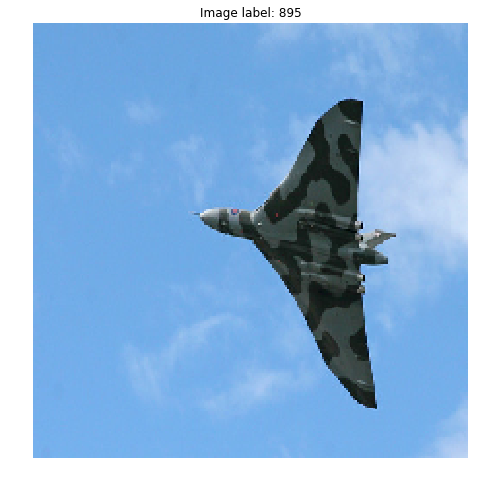

In [164]:
plt.figure(figsize=(8,8))

filename = './data/warplane2.jpg'
label=895 # lista of labels: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

src = load_img(filename, target_size=(224, 224))
img_arr = img_to_array(src)


plt.imshow(np.uint8(img_arr))
plt.axis('off')
plt.title('Image label: 895')
plt.show()


### run the attack

According to the foolbox documentation, the attack uses L-BFGS-B algorithm to minimize 
    - the distance between the image and the adversarial, and
    - the cross-entropy between the predictions for the adversarial and the one-hot encoded target class.

The target class, in this example, is ImageNet's label for spaceship: **812**.

Foolbox's *TargetClassProbability* defines adversarials as images for which the probability of a given target class is above a given threshold.

In [163]:
attack = LBFGSAttack(model=fmodel, 
                     criterion=TargetClassProbability(812, p=.5))

adversarial = attack(img_arr[:, :, ::-1], label)


###  Distance

Calculating the difference in the distance between the original image and the adversarial example explains the amount of perturbtation introduced by the attack. First, let's take a look at the range of the perturbation added.

##### Difference

In [253]:
difference = adversarial[:, :, ::-1] - img_arr

print('Min:', difference.min(),
      'Max:', difference.max())

Min: -2.4273376  Max 2.408661


##### Mean Squared Distance

In [238]:
from foolbox.distances import MeanSquaredDistance as MSD

# The min = 0 and max = 255
bounds = img_arr.min(), img_arr.max()

distance_arr_adv= MSD(reference=img_arr, 
                      other=adversarial, 
                      bounds=bounds)

print(distance_arr_adv)

normalized MSE = 1.10e-01


Accordingly, the average change in pixel value caused by the attack is 0.11. The original image used in this excercise has a dimension of `224x224x3 or 1x150,528`.

###### Augment values for plotting

In [254]:
agumentated_diff = difference / abs(difference).max()*0.5+0.5
agumentated_diff.min(),agumentated_diff.max()

(0.0, 0.9961528)

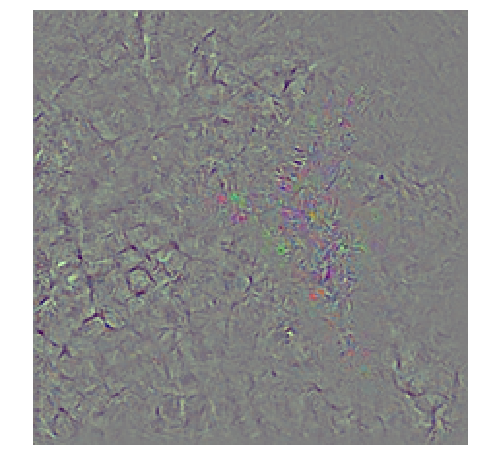

In [255]:
plt.figure(figsize=(8,8))

plt.imshow(agumentated_diff)
plt.axis('off')
plt.show()

### Evaluation

In [269]:

predict_original_img = np.argmax(fmodel.predictions(img_arr))
original_confidence = foolbox.utils.softmax(fmodel.predictions(img_arr))[895]
predict_adversary_img = np.argmax(fmodel.predictions(adversarial))  
adversary_confidence = foolbox.utils.softmax(fmodel.predictions(adversarial))[812]


print("original image's label prediction: ", predict_original_img)
print("original label prediction confidence: ", original_confidence)
print("")
print("adversarial example's label prediction: ", predict_adversary_img)
print("adversary label prediction confidence: ", adversary_confidence)


original image's label prediction:  895
original label prediction confidence:  0.9432986

adversarial example's label prediction:  812
adversary label prediction confidence:  0.9823187
